# Assigment 2: Non-linear optimization

In this assignment we are going to work with a (binary) classification model known as a logistic or logit model. For this classification problem we will assume that we have collected observations $x \in \mathbb{R}^p$, ( $p$ observed values for each observation) belonging to two different classes, $A$ and $B$. We will codify these classes using the value of a variable $y$, so that $y=1$ if $x$ belongs to class $A$, and $y=0$ if $x$ belongs to class $B$.

Our classification procedure will be based on (finding and) using a linear function, if it exists, of the form
$$
\beta^T x=\beta_0+\beta_1 x_1+\cdots+\beta_p x_p,
$$
that takes (large) positive scalar values for observations in $A$ and (large) negative values for observations in $B$.

To improve the interpretability of the results (and the fitting of the model), the value of the preceding linear function is transformed into a value in the interval $[0,1]$. Values close to 1 should indicate a high probability for an observation to belong to class $A$, and values close to 0 should indicate observations in $B$ (with high probability).

The transformation used in logit models, based on the logistic function, is given by
$$
\hat{y}=\frac{1}{1+\exp \left(-\beta^T x\right)} \equiv \varphi(\beta ; x),
$$
where $\hat{y}$ denotes the value predicted by the model.
We will consider one optimization procedure to obtain the values of $\beta$ from a sample of values $\left\{\left(x_i, y_i\right)\right\}_{i=1}^n$ :
- Maximum likelihood: We obtain $\beta$ as the maximizer of the logarithm of the likelihood function,
$$
\max _\beta \sum_{i=1}^n y_i \log \varphi\left(\beta ; x_i\right)+\sum_{i=1}^n\left(1-y_i\right) \log \left(1-\varphi\left(\beta ; x_i\right)\right) .
$$

For a given training set of observations $x_i, i=1, \ldots, n$, with known classes $y_i$, we wish to find values for the vector of $(p+1)$ parameters $\beta$ that provide the best possible fit between the values of $\hat{y}_i$ from (1) and $y_i$, using the the preceding method.

## 1. Generate random Data

In [1]:
#Defining the libraries needed for all the notebook
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize



In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Generating coefficients (beta values)
coefficients = np.random.randint(-10, 11, size=21)

# Step 2: Generating Feature Matrix
n = 1000  # Number of observations
p = 20    # Number of variables

X_0 = np.random.normal(0, 1, size=(n, p))  # Feature matrix with standard normal distribution
intercept_column = np.ones((n, 1))  # Column of ones for intercept term
X = np.concatenate([intercept_column, X_0], axis=1)  # Concatenate intercept column with feature matrix

# Step 3: Creating Linear Relationship
y_lin = np.dot(X, coefficients)

# Step 4: Introducing Random Error (Noise)
noise_scale = 0.1
error = np.random.normal(0, noise_scale, size=n)
y_lin_with_error = y_lin + error

# Applying sigmoid function to get probabilities
probabilities = 1 / (1 + np.exp(-y_lin_with_error))

# Generating binary outcomes from probabilities
y = np.random.binomial(1, probabilities)

# Step 6: Final Outputs
# Creating a DataFrame for better visualization
df = pd.DataFrame(data=np.column_stack([X, y]), columns=[f'X{i}' for i in range(p+1)] + ['y'])

# Displaying the first few rows of the synthetic dataset
df.head()


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,y
0,1.0,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,1.465649,...,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,-0.601707,1.852278,0.0
1,1.0,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0.738467,...,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,0.324084,-0.385082,1.0
2,1.0,-0.676922,0.611676,1.031000,0.931280,-0.839218,-0.309212,0.331263,0.975545,-0.479174,...,-1.196207,0.812526,1.356240,-0.072010,1.003533,0.361636,-0.645120,0.361396,1.538037,0.0
3,1.0,-0.035826,1.564644,-2.619745,0.821903,0.087047,-0.299007,0.091761,-1.987569,-0.219672,...,-0.518270,-0.808494,-0.501757,0.915402,0.328751,-0.529760,0.513267,0.097078,0.968645,0.0
4,1.0,-0.702053,-0.327662,-0.392108,-1.463515,0.296120,0.261055,0.005113,-0.234587,-1.415371,...,-0.802277,-0.161286,0.404051,1.886186,0.174578,0.257550,-0.074446,-1.918771,-0.026514,0.0


## 2. Benchmark

Before starting to develop all the algorithms, we need to set a benckmark to now which are the optimum values of the coefficients. This will be achieved by using the Sklearn library.

In [3]:
# Extracting feature matrix (X) and target variable (y) from the synthetic dataset
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Initializing Logistic Regression model
logreg = LogisticRegression(fit_intercept=False, penalty=None)

# Fitting the model to the data
logreg.fit(X, y)

# Retrieving the coefficients
coefficients_sklearn = logreg.coef_[0]

# Displaying the coefficients
print("Coefficients from scikit-learn Logistic Regression:")
print(coefficients_sklearn)


Coefficients from scikit-learn Logistic Regression:
[ -6.6471181   13.09712764   5.54476347   0.60850717  -4.37536861
  15.4234554   -6.12695097  11.07404149   0.28626125  -0.77592453
  14.21346492 -10.61611577  -4.21515871 -11.42759261  14.39700086
 -13.19186325   1.6815038   -7.37197745 -12.55533901  14.16983971
 -13.1547349 ]


## 3. Optimization with scipy.optimize

Next step would be to estimate the coefficients using the module Scipy.optimize. However, before we have defined the necessary functions of the objective function (Negative Log-Likelihood), its gradient and its hessian, that would be necessary for the following sections.

In [4]:
# Objective function value (Negative Log-Likelihood)
def objective_function(coefficients, X, y):
    logits = np.dot(X, coefficients)
    log_likelihood = np.sum(y * logits - np.log(1 + np.exp(logits)))
    return -log_likelihood
    
# Gradient of the objective function
def gradient(coefficients, X, y):
    logits = np.dot(X, coefficients)
    probabilities = 1 / (1 + np.exp(-logits))
    gradient = np.dot(X.T, y - probabilities)
    return -gradient

# Hessian of the objective function
def hessian(coefficients, X):
    logits = np.dot(X, coefficients)
    probabilities = 1 / (1 + np.exp(-logits))
    diagonal = probabilities * (1 - probabilities)
    hessian_matrix = np.dot(X.T * diagonal, X)
    return -hessian_matrix

Now we are ready to use the module on scipy, from which we have chosen four different solution algorithms to compare:
- **CG**: conjugate gradient algorithm can be regarded as being between the method of gradient descent (first-order method that uses
gradient) and Newton’s method (second-order method that uses Hessian as well).
- **SLSQP**: Sequential Least Squares Programming methods solve a sequence of optimization subproblems, each of which optimizes a quadratic model of the objective subject to a linearization of the constraints. If the problem is unconstrained, then the method reduces to Newton's method for finding a point where the gradient of the objective vanishes. If the problem has only equality constraints, then the method is equivalent to applying Newton's method to the first-order optimality conditions, or Karush–Kuhn–Tucker conditions, of the problem.

- **BFGS**:  Broyden–Fletcher–Goldfarb–Shanno algorithm is an iterative method that determines the descent direction by preconditioning the gradient with curvature information. It gradually improves an approximation to the Hessian matrix of the loss function, obtained only from gradient evaluations (or approximate gradient evaluations) via a generalized secant method.

- **Newton-CG**: combination of Newton's method and conjugate gradient. Newton's method works similarly to gradient descent but uses curvature information (i.e. the second derivative) to take a more direct route.

In [5]:
# Function to perform optimization with scipy
def optimize_and_measure(method, X, y):
    start_time = time.time()
    result = minimize(objective_function, x0=np.zeros(X.shape[1]), args=(X, y),
                      jac=gradient, method=method)
    end_time = time.time()

    obj_func_value= objective_function(result.x, X, y)
    performance = {
        'Method': method,
        'Number of Iterations': result.nit,
        'Number of Function Evaluations': result.nfev,
        'Number of Gradient Evaluations': result.njev,
        'Computational Time': end_time - start_time,
        'Coefficients': result.x,
        'Objective function value': obj_func_value
    }

    return performance

# Create a list to store performance metrics
performance_list = []
methods = ['CG', 'SLSQP', 'BFGS', 'Newton-CG']

# Perform optimization and measure performance for each method
for method in methods:
    performance = optimize_and_measure(method, X, y)
    performance_list.append(performance)

# Convert the list of dictionaries to a DataFrame
performance_df = pd.DataFrame(performance_list)

# Print the performance DataFrame
performance_df



C:\Users\victoria\AppData\Local\Temp\ipykernel_18272\3610883718.py:4: RuntimeWarning: overflow encountered in exp
  log_likelihood = np.sum(y * logits - np.log(1 + np.exp(logits)))


,Method,Number of Iterations,Number of Function Evaluations,Number of Gradient Evaluations,Computational Time,Coefficients,Objective function value
0,CG,180,299,299,0.089515,"[-6.647102840450196, 13.09713899640153, 5.5447...",32.962523
1,SLSQP,39,73,39,0.013997,"[-6.647488925918976, 13.097580567533575, 5.544...",32.962524
2,BFGS,101,115,115,0.044514,"[-6.647193605260614, 13.097310364594515, 5.544...",32.962523
3,Newton-CG,19,21,312,0.045009,"[-6.647196771086186, 13.097315674198935, 5.544...",32.962523


We observed that the most rapid method, SLSQP, achieved convergence in a mere 0.02 seconds. Interestingly, despite not having the fewest iterations, the Newton-CG method outperformed others by combining conjugate gradient and Newton's method, necessitating fewer iterations for convergence. However, this approach expended more time on gradient evaluations.

While most methods exhibited efficient performance, the slowest among them was the conjugate gradient method, consuming almost 0.1 seconds. This is expected given its simplicity compared to the others. Notably, both CG and BFGS required the same number of function and gradient evaluations, whereas the remaining methods varied in this regard.

Generally, all four methods proved suitable for our current problem, as none of them excessively prolonged the computational time. However, with a larger dataset, it might be worth considering SLSGP over the others for enhanced efficiency.

## 4. Unconstrained optimization methods 

### 4.1. Gradient method 

The gradient method operates on the principle of moving in the direction of the steepest decrease in the function's value. To achieve this, it requires fine-tuning through an appropriate step size. In our implementation, we incorporated the Armijo rule, a valuable tool for dynamically adjusting the step size (alpha) to guarantee a significant reduction in the objective function. The convergence of this method is visually represented through an error plot, offering insights into its iterative progress.






Gradient Descent Optimization Result:
Coefficients: [ -6.63553818  13.0754324    5.53490512   0.60745778  -4.36776235
  15.39668918  -6.11584515  11.05518422   0.28612886  -0.77415297
  14.18860996 -10.59773078  -4.20807768 -11.40789597  14.37180425
 -13.16975828   1.67909886  -7.35885003 -12.53399269  14.14569705
 -13.1321585 ]
Number of iterations: 5000
Computational time: 5.248100280761719
Final Log-Likelihood value:  32.96256075723893


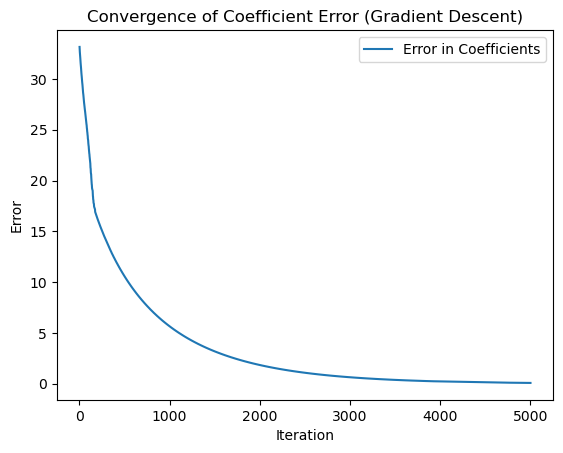

In [6]:
def armijo_rule(coefficients, X, y, ddirect, alpha, sigma, delta):
    while objective_function(coefficients + alpha * ddirect, X, y) > \
          objective_function(coefficients, X, y) + alpha * sigma * np.dot(ddirect, gradient(coefficients, X, y)):
        alpha = alpha * delta
    return alpha

# Gradient Descent Optimization with Armijo rule for Negative Log-Likelihood
def gradient_descent(X, y, learning_rate=0.01, max_iterations=1000, epsilon=1e-6, sigma=0.1, delta=0.1):
    start_time = time.time()

    num_samples, num_features = X.shape
    coefficients = np.zeros(num_features)

    OF_iter = np.zeros(max_iterations)
    tol_iter = np.zeros(max_iterations)
    alpha_iter = np.zeros(max_iterations)
    error_iter = np.zeros(max_iterations)


    for i in range(max_iterations):
        grad = gradient(coefficients, X, y)
        ddirect = -grad

        # Armijo rule to adjust alpha
        alpha = learning_rate
        alpha = armijo_rule(coefficients, X, y, ddirect, alpha, sigma, delta)

        coefficients = coefficients + alpha * ddirect

        OF_iter[i] = objective_function(coefficients, X, y)
        tol = np.linalg.norm(grad, ord=2)
        error_iter[i] = np.linalg.norm(coefficients - coefficients_sklearn, ord=2)

        if tol < epsilon:
            break

    end_time = time.time()
    elapsed_time= end_time - start_time
    return coefficients, i + 1, elapsed_time , error_iter[:i+1]

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Perform gradient descent optimization with Armijo rule and L2 regularization for Negative Log-Likelihood
coeff_GD, num_iter_GD, time_GD, error_GD = gradient_descent(X, y, learning_rate=0.5, max_iterations=5000, epsilon=1e-8, sigma=0.1, delta=0.5)

# Print the results
print("\nGradient Descent Optimization Result:")
print("Coefficients:", coeff_GD)
print("Number of iterations:", num_iter_GD)
print("Computational time:", time_GD)

# Calculate the value of the objective function with the optimal coefficients
optimal_value = objective_function(coeff_GD, X, y)
print("Final Log-Likelihood value: ", optimal_value)

# Plot the convergence of the error
plt.plot(range(1, num_iter_GD + 1), error_GD, label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error (Gradient Descent)")
plt.legend()
plt.show()



By examining the convergence plot of the gradient method, we can discern the method's seamless approximation towards the correct coefficients. It rapidly approaches proximity in the initial stages, only ty reach a plateau as it progresses towards completion.

### 4.2. Newton method

The Newton method is based on the idea of iteratively refining an initial guess for the optimal solution by using information from the first and second derivatives of the objective function. It leverages the gradient (first derivative) and the Hessian (second derivative) to determine the direction and magnitude of the updates, aiming to converge rapidly towards the minimum of the function.


Newton's Method Optimization Result:
Coefficients: [ -6.6471465   13.09722157   5.54482148   0.60850616  -4.37539134
  15.42355902  -6.12700706  11.07410525   0.2862649   -0.77592951
  14.21356564 -10.61618327  -4.21518442 -11.4276721   14.39710401
 -13.19194245   1.68150942  -7.37202231 -12.55543346  14.16993916
 -13.15482852]
Number of Iterations:  57
Computational Time: 0.056549787521362305
Final Log-Likelihood value:  32.96252345559659


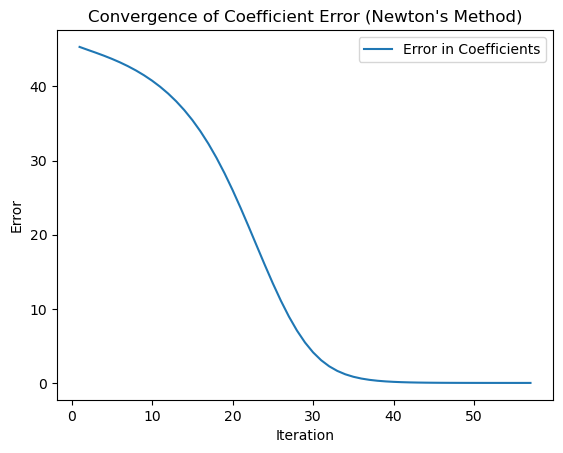

In [7]:
def newton_method(X, y, initial_coefficients, learning_rate= 0.1, max_iterations=500, tolerance=1e-5, sigma=0.1, delta=0.5):
    start_time = time.time()
    coefficients = initial_coefficients.copy()

    num_features = X.shape[1]
    OF_iter = np.zeros(max_iterations)
    tol_iter = np.zeros(max_iterations)
    error_iter = np.zeros(max_iterations)

    for iteration in range(max_iterations):
        grad = gradient(coefficients, X, y)
        hess = hessian(coefficients, X)
        ddirect = np.dot(np.linalg.inv(hess), grad)

        # Armijo rule to adjust alpha
        alpha = learning_rate
        alpha = armijo_rule(coefficients, X, y, ddirect, alpha, sigma,delta)

        # Update coefficients using the Newton-Raphson update rule
        coefficients = coefficients + alpha * ddirect

        # Calculate the objective function value at each iteration
        OF_iter[iteration] = objective_function(coefficients, X, y)

        # Calculate the tolerance at each iteration
        tol_iter[iteration] = np.linalg.norm(grad)

        # Calculate the error at each iteration
        error_iter[iteration] = np.linalg.norm(coefficients - coefficients_sklearn, ord=2)

        # Check for convergence
        if tol_iter[iteration] < tolerance:
            break
    end_time =  time.time()
    time_elapsed = end_time- start_time

    return coefficients, iteration + 1, time_elapsed, error_iter[:iteration+1]

# Using the generated dataset from the previous example
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

initial_coefficients = np.zeros(X.shape[1])

# Use Newton's method to find optimal coefficients
coeff_newton, num_iter_newton, time_newton, error_iter_newton = newton_method(
    X, y, initial_coefficients, learning_rate= 0.3, max_iterations=500, tolerance=1e-5, sigma=0.1, delta=0.5)

# Print the result
print("\nNewton's Method Optimization Result:")
print("Coefficients:", coeff_newton)
print("Number of Iterations: ", num_iter_newton)
print("Computational Time:", time_newton)

# Calculate the value of the objective function with the optimal coefficients
optimal_value_newton = objective_function(coeff_newton, X, y)
print("Final Log-Likelihood value: ", optimal_value_newton)

# Plot the convergence of the error
plt.plot(range(1, num_iter_newton + 1), error_iter_newton, label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error (Newton's Method)")
plt.legend()
plt.show()


In contrast to gradient descent, Newton's method for approximating real coefficients exhibits a distinctive pattern. It initiates the learning process slowly but undergoes rapid convergence, ultimately reaching the real values towards the final iterations.

### 4.3. Quasi-newton method

The Quasi-Newton method is founded on the concept of iteratively improving an initial estimate for the optimal solution without explicitly computing the Hessian matrix. Instead of using the true second derivatives, it approximates them using the information from the first derivatives. Notable examples include the Broyden-Fletcher-Goldfarb-Shanno (BFGS) method, which adjusts the approximation iteratively to efficiently converge towards the function's minimum. This approach seeks a balance between computational efficiency and accurate estimation of the curvature of the objective function.


Quasi-Newton Optimization Result with L-BFGS Update:
Coefficients: [ -6.64719327  13.09730869   5.54486096   0.60850924  -4.37542189
  15.42366779  -6.12705222  11.07418168   0.28626389  -0.77593658
  14.21366554 -10.61625759  -4.215213   -11.42775156  14.39720542
 -13.19203154   1.68152012  -7.37207501 -12.5555199   14.17003557
 -13.15491926]
Number of iterations:  82
Computational time: 0.07161140441894531
Final Log-Likelihood value:  32.96252345493218


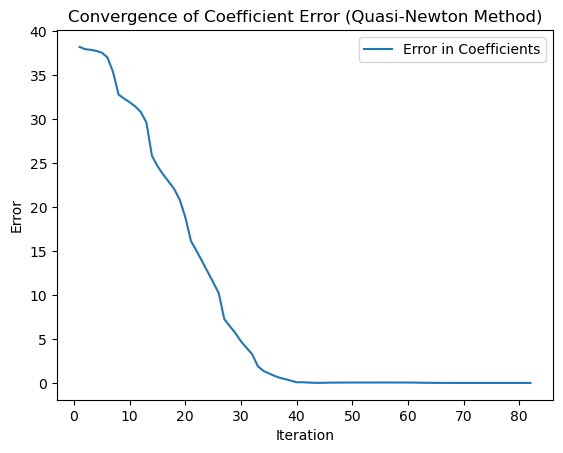

In [8]:
def l_bfgs_update(yk, sk, rho, M):
    m = len(yk)
    alpha = np.zeros(m)
    beta = np.zeros(m)

    q = np.copy(M)
    for i in range(m):
        alpha[i] = rho[i] * np.dot(q, sk[i])
        q -= alpha[i] * yk[i]

    gamma = np.dot(yk[-1], sk[-1]) / np.dot(yk[-1], yk[-1]) if m > 0 else 1.0
    r = gamma * q

    for i in range(m-1, -1, -1):
        beta[i] = rho[i] * np.dot(r, yk[i])
        r += (alpha[i] - beta[i]) * sk[i]

    return r

def quasi_newton_method(X, y, max_iter=500, tol=1e-5, learning_rate= 0.3):
    start_time = time.time()
    coefficients = np.zeros(X.shape[1])
    m = 5  # Number of corrections used in the L-BFGS update
    sk_list = []
    yk_list = []
    rho_list = []
    
    OF_iter = np.zeros(max_iter)
    tol_iter = np.zeros(max_iter)
    error_iter = np.zeros(max_iter)

    for iteration in range(max_iter):
        grad = gradient(coefficients, X, y)
        step = -l_bfgs_update(yk_list, sk_list, rho_list, grad)

        alpha = learning_rate

        # Apply Armijo rule
        alpha = armijo_rule(coefficients, X, y, step, alpha, 0.1, 0.5)

        new_coefficients = coefficients + alpha * step
        new_grad = gradient(new_coefficients, X, y)

        if iteration > 0:
            yk = new_grad - grad
            sk = new_coefficients - coefficients
            rho = 1.0 / np.dot(yk, sk)

            if np.isfinite(rho):
                if len(yk_list) == m:
                    yk_list.pop(0)
                    sk_list.pop(0)
                    rho_list.pop(0)

                yk_list.append(yk)
                sk_list.append(sk)
                rho_list.append(rho)

        # Calculate the objective function value at each iteration
        OF_iter[iteration] = objective_function(new_coefficients, X, y)

        # Calculate the tolerance at each iteration
        tol_iter[iteration] = np.linalg.norm(new_grad)

        # Calculate the error at each iteration
        error_iter[iteration] = np.linalg.norm(new_coefficients - coefficients_sklearn, ord=2)

        # Check for convergence
        if tol_iter[iteration] < tol:
            break

        coefficients = new_coefficients
        
    end_time = time.time()
    elapsed_time= end_time - start_time
    return coefficients, iteration + 1, elapsed_time, error_iter[:iteration+1]

# You need to have X and y defined before using this example
coeff_q_newton, n_iter_q_newton, time_q_newton, error_iter_q_newton = quasi_newton_method(X, y, max_iter=500, tol=1e-5, learning_rate= 0.3)

# Print the results
print("\nQuasi-Newton Optimization Result with L-BFGS Update:")
print("Coefficients:", coeff_q_newton)
print("Number of iterations: ",n_iter_q_newton)
print("Computational time:", time_q_newton)

# Calculate the value of the objective function with the optimal coefficients
optimal_value_q_newton = objective_function(coeff_q_newton, X, y)
print("Final Log-Likelihood value: ", optimal_value_q_newton)

# Plot the convergence of the error
plt.plot(range(1, n_iter_q_newton + 1), error_iter_q_newton, label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error (Quasi-Newton Method)")
plt.legend()
plt.show()



Finallyy, we can note that the convergence of the quasi-Newton method differs from the other two approaches. This discrepancy arises from its reliance on an approximation of the Hessian matrix rather than a complete computation, resulting in a less smooth convergence pattern.

### 4.4. Comparison

In [9]:
data = {
    'Num Iter': [num_iter_GD, num_iter_newton, n_iter_q_newton],
    'Time': [time_GD, time_newton, time_q_newton]
}

methods = ['Gradient Descent', 'Newton', 'Quasi-Newton']
results_part1 = pd.DataFrame(data, index=methods)

# Displaying the DataFrame
results_part1

,Num Iter,Time
Gradient Descent,5000,5.248100
Newton,57,0.056550
Quasi-Newton,82,0.071611


On the one hand, gradient descent exhibits a prolonged convergence process, necessitating a substantial 5000 iterations. This results in a comparatively higher computational time of 5.112062 seconds. While effective, it is less efficient than the rest. 

On the other hand, Newton method showcases remarkable efficiency with a mere 57 iterations, suggesting rapid convergence. The execution time is notably low at 0.040270 seconds, making it a compelling choice for scenarios where quick optimization is essential.

Finally, quasi-Newton algorithm strikes a balance between the two extremes. With 82 iterations, it achieves convergence at a faster pace than gradient descent but not as swiftly as Newton's method. The computational time, at 0.058997 seconds, places it as a viable compromise between efficiency and time requirements.

To conclude, for our problem where the data size is acceptable and the hessian computation is not expensive, the Newton's method strikes a balance between rapid convergence and computational efficiency, making it the preferred choice.

## 5. Noise reduction and Second Order Methodss

### 5.1. Coordinated gradient 

The coordinate gradient descent method is an optimization algorithm that iteratively updates one variable at a time, holding the others fixed. By focusing on one coordinate at a time, the method navigates through the space, converging towards the optimal solution. The algorithm continues this process until a satisfactory convergence criterion is met, effectively optimizing the objective function. 

Coefficients: [ -7.51454341  14.73123122   6.29639777   0.68999362  -4.94891936
  17.43473101  -6.96684515  12.49129957   0.29550628  -0.90482933
  16.08668027 -11.99954375  -4.74824124 -12.91410697  16.290699
 -14.84943296   1.85780842  -8.36233294 -14.1625071   15.99394318
 -14.86463532]
Number of Iterations: 7347
Computational Time: 1.1718485355377197
Objective function value: 33.14523952742021


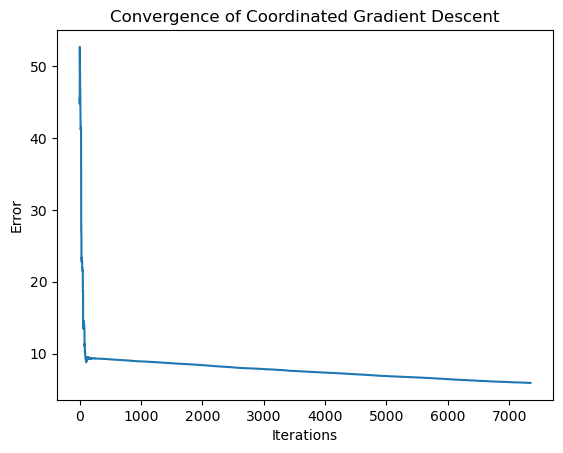

In [10]:
def coordinate_gradient_descent(X, y, initial_coefficients, learning_rate=0.15, num_iterations=10000, tol=1e-10):
    start_time = time.time()

    coefficients = initial_coefficients.copy()
    prev_objective_value = float('inf')
    num_features = len(coefficients)
    errors = []

    for iteration in range(num_iterations):
        j = np.random.randint(num_features)  # Randomly select a coordinate to update
        old_coefficient = coefficients[j]

        # Update the j-th coefficient
        logits = np.dot(X, coefficients)
        probabilities = 1 / (1 + np.exp(-logits))
        gradient_j = np.sum(X[:, j] * (y - probabilities))
        coefficients[j] += learning_rate * gradient_j

        # Update the objective function value
        objective_value = objective_function(coefficients, X, y)

        # Check for convergence
        if np.abs(objective_value - prev_objective_value) < tol:
            break

        # Compute and store the error after the convergence check
        error = np.linalg.norm(coefficients - coefficients_sklearn)
        errors.append(error)

        prev_objective_value = objective_value

    elapsed_time = time.time() - start_time
    
    return coefficients, errors, iteration, elapsed_time


initial_coefficients = np.zeros(X.shape[1])

coeff_coord_GD, error_coord_GD, n_iter_coord_GD, time_coord_GD = coordinate_gradient_descent(X, y, initial_coefficients, learning_rate=0.15, num_iterations=10000, tol=1e-12)

print("Coefficients:", coeff_coord_GD)
print("Number of Iterations:", n_iter_coord_GD)
print("Computational Time:", time_coord_GD)
print('Objective function value:', objective_function(coeff_coord_GD, X, y))


# Now you can use the 'errors' list to plot the convergence of the algorithm
plt.plot(range(1, n_iter_coord_GD + 1), error_coord_GD)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Convergence of Coordinated Gradient Descent')
plt.show()


In contrast to the preceding methods, coordinated gradient descent, and subsequent second-order methods, do not attain optimal coefficients due to their reliance on randomization. As they approach the solution, it becomes challenging for them to precisely converge to the exact optimal solution.

### 5.2. Mini-batch gradient descent 

#### 5.2.1. Without momentum

Mini-batch gradient descent is a variation of the gradient descent optimization algorithm where, instead of updating the model parameters based on the entire dataset, it operates on small random subsets or "mini-batches" of the dataset. The algorithm divides the dataset into mini-batches, and each mini-batch is used to compute the gradient of the loss function with respect to the model parameters. The model parameters are then updated based on this gradient. This process is repeated iteratively for each mini-batch until convergence.


Mini-Batch Gradient Descent Optimization Result with Armijo Rule for Negative Log-Likelihood:
Coefficients:  [ -6.81729972  13.58135692   5.48953201   0.75830783  -4.43454394
  15.51073836  -6.44122317  11.59779969   0.3400269   -0.77924177
  14.44070713 -10.19312093  -3.94540279 -11.55751756  14.25584566
 -13.45436086   1.94912533  -7.17057374 -12.76830386  14.40131794
 -13.30422376]
Number of iterations: 15000
Computational time:  3.758296012878418
Final Negative Log-Likelihood: 38.40185005824462


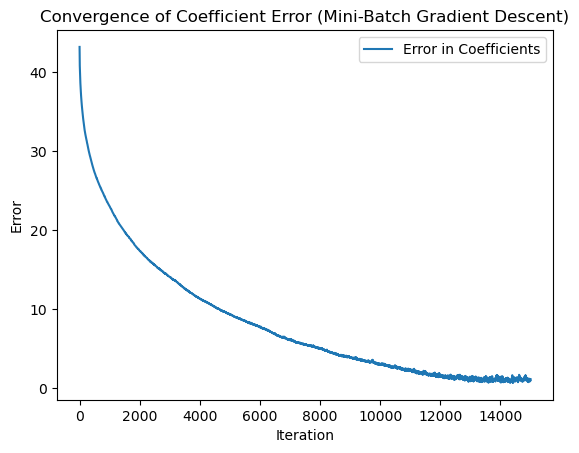

In [11]:
def mini_batch_gradient_descent(X, y, batch_size=64, learning_rate=0.1, max_iterations=2000, epsilon=1e-3, sigma=0.1, delta=0.1):
    start_time = time.time()

    num_samples, num_features = X.shape
    coefficients = np.zeros(num_features)

    OF_iter = np.zeros(max_iterations)
    tol_iter = np.zeros(max_iterations)
    alpha_iter = np.zeros(max_iterations)
    error_iter = np.zeros(max_iterations)

    for i in range(max_iterations):
        indices = np.random.choice(num_samples, batch_size, replace=False)
        X_batch = X[indices, :]
        y_batch = y[indices]

        grad = gradient(coefficients, X_batch, y_batch)
        ddirect = -grad

        # Armijo rule to adjust alpha
        alpha = learning_rate
        alpha = armijo_rule(coefficients, X_batch, y_batch, ddirect, alpha, sigma, delta)

        coefficients = coefficients + alpha * ddirect

        OF_iter[i] = objective_function(coefficients, X, y)
        tol = np.linalg.norm(grad, ord=2)
        tol_iter[i] = tol
        alpha_iter[i] = alpha

        error_iter[i] = np.linalg.norm(coefficients - coefficients_sklearn, ord=2)

        if tol < epsilon:
            break

    end_time = time.time()
    elapsed_time = end_time - start_time

    return coefficients, i + 1, elapsed_time, error_iter[:i+1]


# Perform mini-batch gradient descent optimization with Armijo rule and L2 regularization for Negative Log-Likelihood
coeff_MB_GD, num_iter_MB_GD, time_MB_GD, error_MB_GD = mini_batch_gradient_descent(
    X, y, batch_size=64, learning_rate=0.1, max_iterations=15000, epsilon=1e-15, sigma=0.1, delta=0.1)

# Print the results
print("\nMini-Batch Gradient Descent Optimization Result with Armijo Rule for Negative Log-Likelihood:")
print("Coefficients: ", coeff_MB_GD)
print("Number of iterations:",num_iter_MB_GD)
print("Computational time: ", time_MB_GD)
print("Final Negative Log-Likelihood:", objective_function(coeff_MB_GD, X,y))



# Plot the convergence of the error
plt.plot(range(1, num_iter_MB_GD + 1), error_MB_GD, label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error (Mini-Batch Gradient Descent)")
plt.legend()
plt.show()


Once more, given its reliance on randomization during the selection of mini-batches, the process exhibits noise as it approaches the optimum. This randomness makes it challenging for the algorithm to precisely attain the exact values of the coefficients.

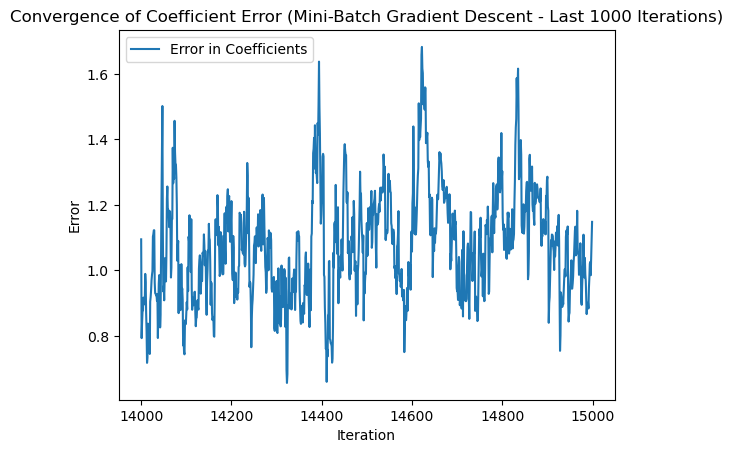

In [12]:
# Plot the convergence of the error
# Extract the last 5000 iterations for plotting
start_iteration = num_iter_MB_GD - 1000
end_iteration = num_iter_MB_GD

# Plot the convergence of the error for the last 5000 iterations
plt.plot(range(start_iteration, end_iteration), error_MB_GD[start_iteration:end_iteration], label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error (Mini-Batch Gradient Descent - Last 1000 Iterations)")
plt.legend()
plt.show()

#### 5.2.2. With momentum



The noise from the mini-batch gradient descent method can be mitigated by incorporating momentum. Momentum is a technique that helps stabilize and accelerate the convergence process by introducing a running average of the past gradients.

In essence, momentum adds a fract β) of the previous update to the current update. This momentum term helps the optimization process to continue in a consistent direction, smoothing out fluctuations caused by the randomness in mini-batch sampling.


Mini-Batch Gradient Descent with Momentum Optimization Result:
Coefficients:  [ -6.21615159  12.77666377   5.54627167   0.51133781  -4.32419878
  15.37751975  -5.89119197  10.86055544   0.23141686  -0.599275
  13.84511917 -10.51520185  -4.48423673 -10.72198672  13.74198904
 -12.99062812   1.48416949  -7.37386408 -12.53347549  14.09135238
 -12.63355615]
Number of iterations: 23000
Computational time:  10.34622597694397
Final Negative Log-Likelihood:  38.57983381257934


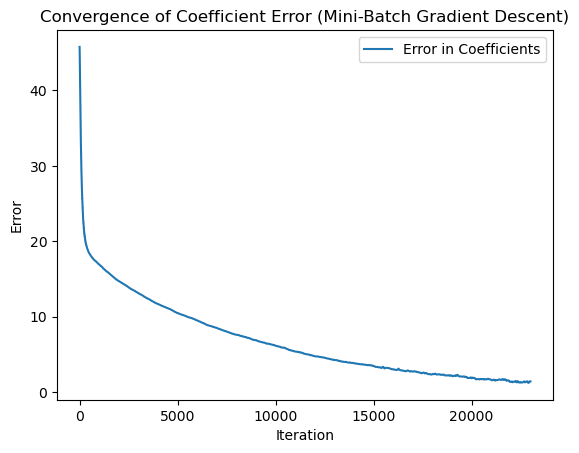

In [13]:
def mini_batch_gradient_descent_momentum(X, y, batch_size=64, learning_rate=0.1, momentum=0.9, max_iterations=2000, epsilon=1e-3, sigma=0.1, delta=0.1):
    start_time = time.time()

    num_samples, num_features = X.shape
    coefficients = np.zeros(num_features)
    
    # Initialize momentum term
    velocity = np.zeros_like(coefficients)

    OF_iter = np.zeros(max_iterations)
    tol_iter = np.zeros(max_iterations)
    alpha_iter = np.zeros(max_iterations)
    error_iter = np.zeros(max_iterations)

    for i in range(max_iterations):
        indices = np.random.choice(num_samples, batch_size, replace=False)
        X_batch = X[indices, :]
        y_batch = y[indices]

        grad = gradient(coefficients, X_batch, y_batch)
        
        # Update velocity using momentum
        velocity = momentum * velocity + (1 - momentum) * grad

        ddirect = -velocity  # Use the momentum term in the direction update

        # Armijo rule to adjust alpha
        alpha = learning_rate
        alpha = armijo_rule(coefficients, X_batch, y_batch, ddirect, alpha, sigma, delta)

        coefficients = coefficients + alpha * ddirect

        OF_iter[i] = objective_function(coefficients, X, y)
        tol = np.linalg.norm(grad, ord=2)
        tol_iter[i] = tol
        alpha_iter[i] = alpha

        error_iter[i] = np.linalg.norm(coefficients - coefficients_sklearn, ord=2)

        if tol < epsilon:
            break

    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return coefficients, i + 1, elapsed_time, error_iter[:i+1]


# Perform mini-batch gradient descent optimization with Armijo rule and L2 regularization for Negative Log-Likelihood
coeff_MB_GD_M64, num_iter_MB_GD_M64, time_MB_GD_M64, error_MB_GD_M64 = mini_batch_gradient_descent_momentum(
    X, y,batch_size=64, learning_rate=0.1, momentum=0.99, max_iterations=23000, epsilon=1e-10, sigma=0.1, delta=0.1)

# Print the results
print("\nMini-Batch Gradient Descent with Momentum Optimization Result:")
print("Coefficients: ", coeff_MB_GD_M64)
print("Number of iterations:", num_iter_MB_GD_M64)
print("Computational time: ",time_MB_GD_M64)
print("Final Negative Log-Likelihood: " , objective_function(coeff_MB_GD_M64, X, y))

# Plot the convergence of the error
plt.plot(range(1, num_iter_MB_GD_M64 + 1), error_MB_GD_M64, label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error (Mini-Batch Gradient Descent)")
plt.legend()
plt.show()


The enhancement brought about by momentum is evident in the noticeable reduction of noise within the algorithm.

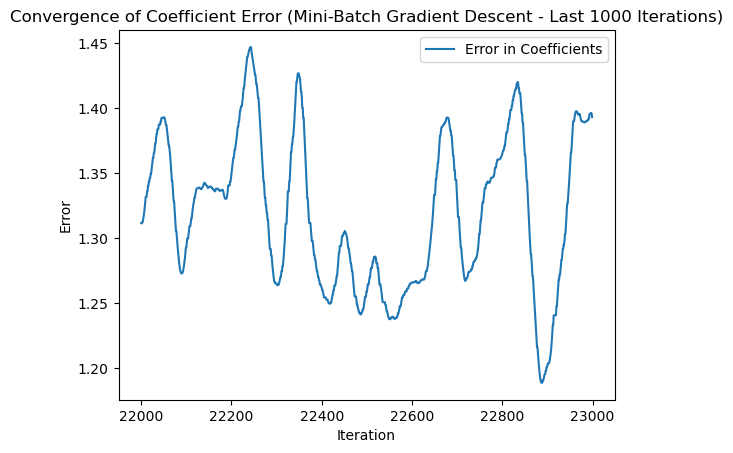

In [14]:
# Plot the convergence of the error
# Extract the last 1000 iterations for plotting
start_iteration = num_iter_MB_GD_M64 - 1000
end_iteration = num_iter_MB_GD_M64

# Plot the convergence of the error for the last 5000 iterations
plt.plot(range(start_iteration, end_iteration), error_MB_GD_M64[start_iteration:end_iteration], label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error (Mini-Batch Gradient Descent - Last 1000 Iterations)")
plt.legend()
plt.show()

##### Comparing mini-bath sizes

Continuing with the mini-batch gradient descent algorithm, one of the critical hyperparameters influencing its performance is the batch size. Consequently, we will assess the results across various batch sizes (32, 64, 128, 256), while keeping the other hyperparameters consistent. It is essential to adjust the maximum number of iterations to maintain a fair comparison, as failing to do so could lead to potential errors in the algorithm's performance assessment.


Mini-Batch Gradient Descent with Momentum Optimization Result:
Coefficients:  [ -6.16454737  12.32951989   5.30923065   0.65010242  -3.79235157
  14.23780431  -5.50535073  10.24809517   0.5934424   -0.76066932
  13.36402823  -9.9825587   -3.83964589 -10.64199063  13.44669247
 -12.38497161   1.70250987  -6.97967793 -12.03245372  13.08837941
 -12.15105026]
Number of iterations: 35000
Computational time:  16.80385684967041
Final Log-Likelihood value:  35.481529190012225


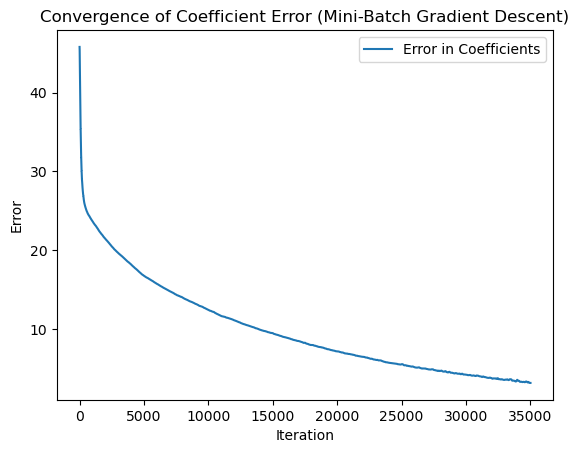

In [15]:
## BATCH = 32
coeff_MB_GD_M32, num_iter_MB_GD_M32, time_MB_GD_M32, error_MB_GD_M32 = mini_batch_gradient_descent_momentum(
    X, y,batch_size=32, learning_rate=0.1, momentum=0.99, max_iterations=35000, epsilon=1e-10, sigma=0.1, delta=0.1)

# Print the results
print("\nMini-Batch Gradient Descent with Momentum Optimization Result:")
print("Coefficients: ", coeff_MB_GD_M32)
print("Number of iterations:", num_iter_MB_GD_M32)
print("Computational time: ",time_MB_GD_M32)
print("Final Log-Likelihood value: " , objective_function(coeff_MB_GD_M32, X, y))


# Plot the convergence of the error
plt.plot(range(1, num_iter_MB_GD_M32 + 1), error_MB_GD_M32, label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error (Mini-Batch Gradient Descent)")
plt.legend()
plt.show()


Mini-Batch Gradient Descent with Momentum Optimization Result:
Coefficients:  [ -6.63486983  13.32046415   6.0707703    0.38301517  -4.39510931
  15.9057707   -6.41077884  11.14818859   0.27741736  -0.50259381
  14.52135947 -10.77257198  -3.99079402 -11.34936783  14.42663819
 -13.19810085   2.21011833  -7.71042485 -12.77446128  14.25234032
 -13.66094312]
Number of iterations: 10000
Computational time:  5.1473023891448975
Final Log-Likelihood value:  36.70008339697428


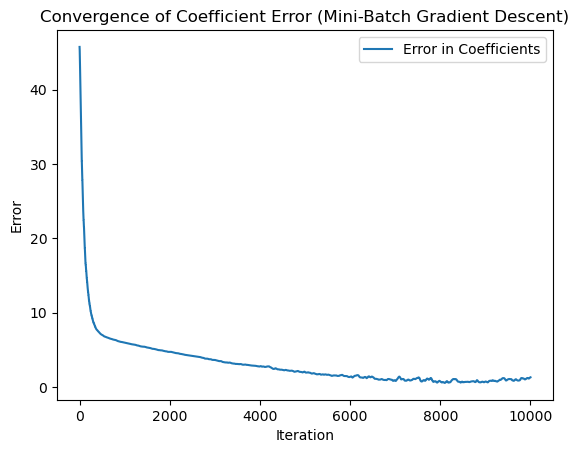

In [16]:
## BATCH = 128
coeff_MB_GD_M128, num_iter_MB_GD_M128, time_MB_GD_M128, error_MB_GD_M128 = mini_batch_gradient_descent_momentum(
    X, y,batch_size=138, learning_rate=0.1, momentum=0.99, max_iterations=10000, epsilon=1e-10, sigma=0.1, delta=0.1)

# Print the results
print("\nMini-Batch Gradient Descent with Momentum Optimization Result:")
print("Coefficients: ", coeff_MB_GD_M128)
print("Number of iterations:", num_iter_MB_GD_M128)
print("Computational time: ",time_MB_GD_M128)
print("Final Log-Likelihood value: " , objective_function(coeff_MB_GD_M128, X, y))

# Plot the convergence of the error
plt.plot(range(1, num_iter_MB_GD_M128 + 1), error_MB_GD_M128, label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error (Mini-Batch Gradient Descent)")
plt.legend()
plt.show()


Mini-Batch Gradient Descent with Momentum Optimization Result:
Coefficients:  [ -6.5614681   13.3781366    5.30579297   0.63674957  -4.44702802
  15.37725807  -6.24426164  11.178644     0.22269265  -1.09598489
  14.4198703  -10.63654348  -4.38755645 -11.45612774  14.54929632
 -13.34626872   1.68515527  -7.36695993 -12.65361751  14.30586004
 -13.22773747]
Number of iterations: 250
Computational time:  0.14605402946472168
Final Log-Likelihood value:  34.26176521015829


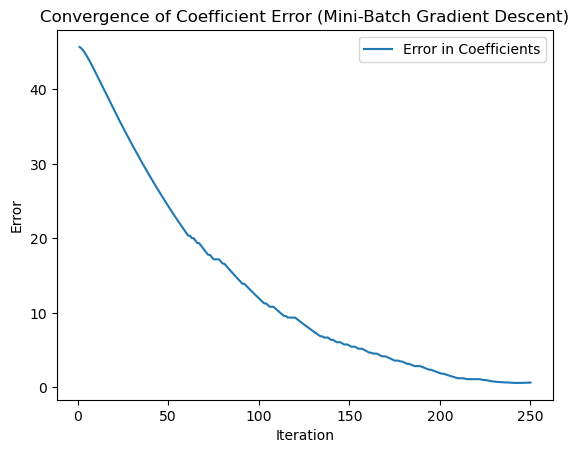

In [17]:
## BATCH = 256
coeff_MB_GD_M256, num_iter_MB_GD_M256, time_MB_GD_M256, error_MB_GD_M256 = mini_batch_gradient_descent_momentum(
    X, y,batch_size=256, learning_rate=0.1, momentum=0.99, max_iterations=250, epsilon=1e-10, sigma=0.1, delta=0.1)

# Print the results
print("\nMini-Batch Gradient Descent with Momentum Optimization Result:")
print("Coefficients: ", coeff_MB_GD_M256)
print("Number of iterations:", num_iter_MB_GD_M256)
print("Computational time: ",time_MB_GD_M256)
print("Final Log-Likelihood value: " , objective_function(coeff_MB_GD_M256, X, y))

# Plot the convergence of the error
plt.plot(range(1, num_iter_MB_GD_M256 + 1), error_MB_GD_M256, label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error (Mini-Batch Gradient Descent)")
plt.legend()
plt.show()

We will be comparing the results at the end of this section.

### 5.3. Hessian free inexact method (second order method)

The key idea behind HFI is to avoid explicitly computing and storing the Hessian matrix, which can be computationally expensive. Instead, it employs iterative techniques to approximate the inverse Hessian-vector product. This allows the algorithm to make efficient updates to the model parameters without the need for full Hessian information.

Coefficients: [ -6.6471233   13.09717778   5.54480199   0.60850402  -4.3753762
  15.42350544  -6.12698512  11.07406746   0.28626423  -0.7759259
  14.21351593 -10.6161464   -4.21517018 -11.42763269  14.39705354
 -13.19189777   1.6815044   -7.37199628 -12.55539052  14.16989082
 -13.15478337]
Number of Iterations: 10000
Computational Time: 2.5145387649536133
Final Log-Likelihood value:  32.962523456374825


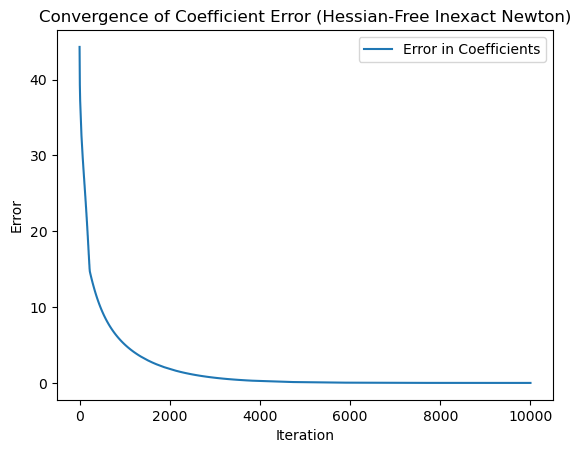

In [18]:
def hessian_vector_product(X, coefficients, vector):
    logits = np.dot(X, coefficients)
    diag = (1 / (1 + np.exp(-logits))) * (1 - (1 / (1 + np.exp(-logits))))
    return np.dot(X.T, diag * np.dot(X, vector))

def hessian_free_inexact_method(X, y, initial_coefficients, tol=1e-5, max_iterations=1000):
    start_time = time.time()
    coefficients = initial_coefficients
    iteration = 0
    step_size = 1.0
    error_iter = np.zeros(max_iterations)

    while iteration < max_iterations:
        logits = np.dot(X, coefficients)
        probabilities= 1 / (1 + np.exp(-logits))
        gradient = np.dot(X.T, y - probabilities)
        gradient_norm = np.linalg.norm(gradient)

        if gradient_norm < tol:
            break

        preconditioned_gradient = gradient / step_size
        search_direction = preconditioned_gradient

        # Compute the Hessian-vector product
        Hv = hessian_vector_product(X, coefficients, search_direction)

        # Compute the step size
        alpha = np.dot(search_direction, gradient) / np.dot(search_direction, Hv)
        coefficients = coefficients + alpha * search_direction

        # Calculate the error at each iteration
        error_iter[iteration] = np.linalg.norm(coefficients - coefficients_sklearn, ord=2)

        iteration += 1

    end_time = time.time()
    elapsed_time = end_time - start_time

    return coefficients, elapsed_time, iteration, error_iter[:iteration]


# Initialize coefficients
initial_coefficients = np.zeros(X.shape[1])

# Run Hessian-Free Inexact Newton optimization
coeff_hessian_free, time_hessian_free, iter_hessian_free, error_hessian_free = hessian_free_inexact_method(
    X, y, initial_coefficients,  tol=1e-6, max_iterations=10000)

# Print the results
print("Coefficients:", coeff_hessian_free)
print("Number of Iterations:", iter_hessian_free)
print("Computational Time:", time_hessian_free,)
print("Final Log-Likelihood value: ", objective_function(coeff_hessian_free, X,y))

# Plot the convergence of the error
plt.plot(range(1, iter_hessian_free + 1), error_hessian_free, label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error (Hessian-Free Inexact Newton)")
plt.legend()
plt.show()


### 5.4. Comparison



In [19]:
data = {
    'Num Iter': [n_iter_coord_GD, num_iter_MB_GD, num_iter_MB_GD_M32, num_iter_MB_GD_M64, num_iter_MB_GD_M128, num_iter_MB_GD_M256, iter_hessian_free],
    'Time': [time_coord_GD, time_MB_GD , time_MB_GD_M32, time_MB_GD_M64, time_MB_GD_M128, time_MB_GD_M256, time_hessian_free],
    'Coefficients': [coeff_coord_GD,coeff_MB_GD , coeff_MB_GD_M32, coeff_MB_GD_M64, coeff_MB_GD_M128, coeff_MB_GD_M256, coeff_hessian_free]
}

methods = ['Coordinated GD', 'Mini-batch no momentum', 'Mini-batch mom 32', 'Mini-batch mom 64', 'Mini-batch mom 128', 'Mini-batch mom 256', 'Hessian free']
results_part2 = pd.DataFrame(data, index=methods)

# Displaying the DataFrame
results_part2


,Num Iter,Time,Coefficients
Coordinated GD,7347,1.171849,"[-7.514543413392819, 14.731231223415936, 6.296..."
Mini-batch no momentum,15000,3.758296,"[-6.817299718406386, 13.581356924441984, 5.489..."
Mini-batch mom 32,35000,16.803857,"[-6.16454736784311, 12.32951989481519, 5.30923..."
Mini-batch mom 64,23000,10.346226,"[-6.216151587656103, 12.776663765013005, 5.546..."
Mini-batch mom 128,10000,5.147302,"[-6.634869825231726, 13.320464153923455, 6.070..."
Mini-batch mom 256,250,0.146054,"[-6.561468100481639, 13.378136603997765, 5.305..."
Hessian free,10000,2.514539,"[-6.647123300350359, 13.097177777541114, 5.544..."


Regarding the batch sizes of the mini-batch gradient descent method, as the mini-batch size increases, the number of iterations generally decreases, indicating that larger batches cover more information in each step. 
The computational time increases withsmaller -batch sizes, which is expected due to the higher amount of data being processed in each iteration

Coordinated Gradient Descent achieves convergence in a relatively lower number of iterations (7347) compared to most mini-batch methods. Futhermore, it converges faster than most of them, and also faster than the hessian free method. However, the Hessian Free method achieves coefficients that are more close to optimal, indicating its effectiveness in reaching the global minimum. This is in contrast to the other methods, which are close but not perfect in achieving the optimal coefficients.

To conclude, the results suggest that different methods have their strengths and weaknesses. 
Coordinated GD converges faster but may not be as computationally efficient 
Mini-batch methods with momentum show sensitivity to t batch sizeue, impacting the trade-off between convergence speed and computational efficienc .
The Hessian Free method appears to strike a balance between the number of iterations and computational time while achieving coefficients closer to the optimal values...

# 6. Constrained problem


Estimate the optimal value of the regression coefficients in the following problem by implementing a penalization algorithm.

$\begin{aligned} \max _\beta & \sum_{i=1}^n y_i \log \varphi\left(\beta ; x_i\right)+\sum_{i=1}^n\left(1-y_i\right) \log \left(1-\varphi\left(\beta ; x_i\right)\right) \\ \text { s.t. } & \sum_{j=0}^p \beta_j^2=100\end{aligned}$

In [20]:
# Set the regularization parameter
lambd = 0.1

# Create and fit the Logistic Regression model with L2 regularization
model = LogisticRegression(penalty='l2', C=1/lambd, solver='lbfgs')
model.fit(X, y)

# Extract the estimated coefficients
result_beta_sklearn = model.coef_[0]

print("Estimated Beta (Scikit-learn):", result_beta_sklearn)


Estimated Beta (Scikit-learn): [-5.76086497e-05  5.13530961e+00  2.07672570e+00  2.17907085e-01
 -1.66873697e+00  5.80570757e+00 -2.25186955e+00  4.27430219e+00
  1.22448341e-01 -1.32352177e-01  5.33568371e+00 -3.95902029e+00
 -1.63347076e+00 -4.32691554e+00  5.41317879e+00 -5.09828297e+00
  6.87997395e-01 -2.75757133e+00 -4.81403374e+00  5.50432353e+00
 -5.11591951e+00]


In [25]:
# Function to compute the log-likelihood with L2 penalty
def log_likelihood_with_penalty(beta, X, y, lambd):
    n = len(y)
    z = np.dot(X, beta)
    log_likelihood = np.sum(y * np.log(1 / (1 + np.exp(-z))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-z))))
    penalty_term = -0.5 * lambd * np.sum(beta**2)
    return log_likelihood + penalty_term

# Function to compute the gradient of the log-likelihood with L2 penalty
def gradient_with_penalty(beta, X, y, lambd):
    n = len(y)
    z = np.dot(X, beta)
    error = 1 / (1 + np.exp(-z)) - y
    gradient = np.dot(X.T, error) - lambd * beta
    return gradient

# Gradient Descent Optimization with Armijo rule for Negative Log-Likelihood
def gradient_descent_with_penalty(X, y, lambd, learning_rate=0.01, max_iterations=1000, epsilon=1e-6, sigma=0.1, delta=0.1):
    start_time = time.time()

    num_samples, num_features = X.shape
    coefficients = np.zeros(num_features)

    OF_iter = np.zeros(max_iterations)
    tol_iter = np.zeros(max_iterations)
    alpha_iter = np.zeros(max_iterations)
    error_iter = np.zeros(max_iterations)

    for i in range(max_iterations):
        grad = gradient_with_penalty(coefficients, X, y, lambd)
        ddirect = -grad

        # Armijo rule to adjust alpha
        alpha = learning_rate
        alpha = armijo_rule(coefficients, X, y, ddirect, alpha, sigma, delta)

        coefficients = coefficients + alpha * ddirect

        OF_iter[i] = log_likelihood_with_penalty(coefficients, X, y, lambd)
        tol = np.linalg.norm(grad, ord=2)
        error_iter[i] = np.linalg.norm(coefficients - result_beta_sklearn, ord=2)  

        if tol < epsilon:
            break

    end_time = time.time()
    elapsed_time = end_time - start_time
    return coefficients, i + 1, elapsed_time, error_iter[:i+1]

# Set the regularization parameter
lambd = 0.1

# Perform gradient descent with penalty
learning_rate = 0.01
max_iterations = 200
result_beta, num_iterations, elapsed_time, error_iter = gradient_descent_with_penalty(X, y, lambd, learning_rate, max_iterations)

print("Estimated Beta:", result_beta)



Estimated Beta: [-2.36471691  4.92631068  1.98988567  0.20714602 -1.5977088   5.55321853
 -2.15563089  4.09650683  0.11371085 -0.1137402   5.1068235  -3.7813933
 -1.56948842 -4.14197062  5.18069119 -4.88132442  0.66016215 -2.63695507
 -4.60773464  5.28062097 -4.91084038]


C:\Users\victoria\AppData\Local\Temp\ipykernel_18272\3410789733.py:5: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(y * np.log(1 / (1 + np.exp(-z))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-z))))
C:\Users\victoria\AppData\Local\Temp\ipykernel_18272\3410789733.py:5: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = np.sum(y * np.log(1 / (1 + np.exp(-z))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-z))))


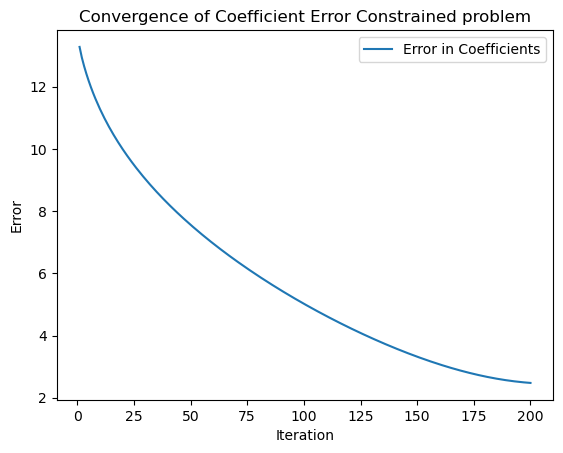

In [26]:
# Plot the convergence of the error
plt.plot(range(1, num_iterations + 1), error_iter, label='Error in Coefficients')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Convergence of Coefficient Error Constrained problem")
plt.legend()
plt.show()